# Train Model



## Set parameters that will control the execution

In [1]:
data_dir = "../_DATA/CarND/p3_behavioral_cloning/set_001/"
image_dir = "IMG/"
driving_data_csv = "driving_log_normalized.csv"
model_dir = "../_DATA/MODELS/"
model_name = "model_p3_14x64x3_"
batch_size = 256
nb_epoch = 40 
model_to_continue_training = "previous_model.h5"
previous_trained_epochs = 30

# Allocate only a fraction of memory to TensorFlow GPU process

In [2]:
# https://github.com/aymericdamien/TensorFlow-Examples/issues/38#issuecomment-265599695
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6) # try range from 0.333 ot .9
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True, gpu_options=gpu_options))

#### Show available CPU and GPU(s)
from tensorflow.python.client import device_lib
def get_available_CPU_GPU():
    devices = device_lib.list_local_devices()
    #return [x.name for x in devices if x.device_type == 'CPU']
    return [x.name for x in devices ]

print(get_available_CPU_GPU())

['/cpu:0', '/gpu:0']


# Fetch data from CSV file

In [3]:
from  DataHelper import read_csv
csv_path = data_dir + driving_data_csv
print("csv_path", csv_path)
headers, data = read_csv(data_dir + driving_data_csv)

Using TensorFlow backend.


csv_path ../_DATA/CarND/p3_behavioral_cloning/set_001/driving_log_normalized.csv
Number of imported CSV rows: 11723


# Split data into training, testing and validation sets

In [4]:
from DataHelper import split_random
training, testing, validation = split_random(data, percent_train=75, percent_test=15) 

print("training", training.shape)
print("testing", testing.shape)
print("validation", validation.shape)

percent_validation 10
training (8792, 7)
testing (1759, 7)
validation (1171, 7)


# Fetch and visualize training steering angles

I would like to train a car on the set that has a nice bell curve distribution of values:
- I can drive the car on the track backwards
- I can flip each image (and value)

min_value -0.893879
max_value 0.965902
spread 1.85978
recommended number of classes 186


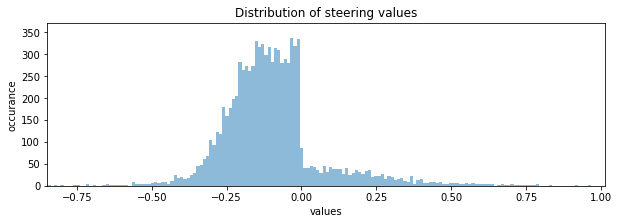

In [5]:
from DataHelper import plot_histogram, get_steering_values, find_nearest
steering_angles = get_steering_values(training)
plot_histogram("steering values", steering_angles, change_step=0.01)

# Extract image names

In [6]:
from DataHelper import get_image_center_values 
image_names = get_image_center_values(training)
print("image count", image_names.shape[0])
print(image_names[1])

image count 8792
center_2017_01_21_01_40_54_537.jpg


# Create a list of image paths

In [7]:
image_paths = []
for image_name in image_names:
    image_paths.extend([data_dir + image_dir + image_name])
print(image_paths[1]) 

../_DATA/CarND/p3_behavioral_cloning/set_001/IMG/center_2017_01_21_01_40_54_537.jpg


# Read images and display a sample

- make sure they are in the right color representation
- use Generator

training_features count 8792
sample_image   (160, 320, 3)


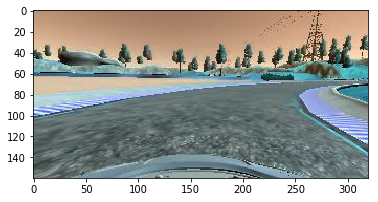

In [8]:
#import numpy as np 
from ImageHelper import read_image_array
training_features = [read_image_array(path) for path in image_paths]

print ("training_features count", len(training_features) )

sample_image = training_features[2]
print ("sample_image  ", sample_image.shape)

import matplotlib.pyplot as plt
plt.imshow(sample_image) # cmap='gray' , cmap='rainbow'
plt.show()

#print(sample_image[0][0:15])

# Import Keras (layer above TensorFlow)

https://keras.io/layers/convolutional/

In [12]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import ELU, InputLayer, Input
from keras.layers.core import Flatten, Dense, Dropout, Activation, Lambda

from keras.activations import relu, softmax
from keras.optimizers import SGD
import cv2, numpy as np
from DataHelper import mean_pred, false_rates

from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Convolution1D

In [14]:
# Build a Convolutional Neural Network

In [13]:
model = Sequential()

model.add(Convolution2D(64, 3, 3, border_mode='same', activation="relu" ,
                        input_shape=(14, 64 ,3), dim_ordering='tf', name="conv2d_1_relu"))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation="relu", name="conv2d_2_relu" ))
model.add(Convolution2D(64, 5, 5, border_mode='same', activation="relu", name="conv2d_3_relu" ))

model.add(Flatten())

#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dense(256, activation="relu", name="dense_1_relu")) #256
model.add(Dropout(0.25, name="dropout_1_0.25"))
model.add(Dense(256, activation="relu", name="dense_2_relu" )) #256

# CLASSIFICATION
model.add(Dense(41, activation='linear' , name="dense_3_41_linear")) # default: linear | softmax | relu | sigmoid

# REGRESSION
#model.add(Dense(1, activation='linear'))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
conv2d_1_relu (Convolution2D)    (None, 14, 64, 64)    1792        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
conv2d_2_relu (Convolution2D)    (None, 14, 64, 64)    36928       conv2d_1_relu[0][0]              
____________________________________________________________________________________________________
conv2d_3_relu (Convolution2D)    (None, 14, 64, 64)    102464      conv2d_2_relu[0][0]              
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 57344)         0           conv2d_3_relu[0][0]              
___________________________________________________________________________________________